# Binance

- Créér un clé API : https://www.binance.com/en/support/faq/360002502072
- **Quand elle est créée garder en mémoire l'api key et la secret KEY**

- créer un fichier config.cfg dans le même répertoire que le notebook et remplacer les valeurs par celles de l'API créée

```cfg
[BINANCE]
API_KEY = YOUR KEY                  
SECRET_KEY = YOUR SECRET KEY        
```



- installer le package python-binance 

```shell
pip install python-binance
ou
py -m pip install python-binance
ou autre
```
- Editer la list my_coins avec vos crypto 
```python
#exemple
my_coins = ['BTC','USDT', 'ETH']     # A ADAPTER
```

- Editer le dict stack car l'API ne sait pas encore récupérer les crypto stackées 

```python
#exemple
stack = {'DOT':3, 'ADA':6.1938, 'CAKE':3.125, 'TRX': 67}      # A ADAPTER
```

- et lancer tout les cellules
! Tout est en dollars


(Il peut y avoir des erreurs de désynchronisation d'horloge. Pour corriger cliquer sur l'heure, puis "paramètre date et heure", puis "synchroniser maintenant")


#### LISTE A COMPLETER

In [1]:
import requests, json, time, hashlib,hmac, configparser
from binance import Client
# A ADAPTER 
my_coins = ['BTC', 'ETH', 'ADA', 'DOT', 'MATIC', 'KSM', 'CAKE', 'VET', 'SOL', 'BNB', 'LTC', 'THETA', 'AVAX', 'DENT', 'EGLD', 'HOT', 'TRX', 'ONE', 'BAND', 'SXP', 'LINK', 'UTK', 'USDT', 'BUSD']  
my_symbols = [coin + 'USDT' for coin in my_coins]

config = configparser.ConfigParser()
config.read_file(open('config.cfg'))

KEY = config.get('BINANCE', 'API_KEY')
SECRET_KEY = config.get('BINANCE', 'SECRET_KEY')
BASE_URL = 'https://api.binance.com/'

client = Client(KEY, SECRET_KEY)


In [2]:
from urllib.parse import urlencode

# fonctions utilitaires

def get_timestamp():
    return int(time.time() * 1000)

def hashing(query_string):
    return hmac.new(SECRET_KEY.encode('utf-8'), query_string.encode('utf-8'), hashlib.sha256).hexdigest()

def dispatch_request(http_method):
    session = requests.Session()
    session.headers.update({
        'Content-Type': 'application/json;charset=utf-8',
        'X-MBX-APIKEY': KEY
    })
    return {
        'GET': session.get,
        'DELETE': session.delete,
        'PUT': session.put,
        'POST': session.post,
    }.get(http_method, 'GET')

def send_signed_request(http_method, url_path, payload={}):
    query_string = urlencode(payload, True)
    if query_string:
        query_string = "{}&timestamp={}".format(query_string, get_timestamp())
    else:
        query_string = 'timestamp={}'.format(get_timestamp())

    url = BASE_URL + url_path + '?' + query_string + '&signature=' + hashing(query_string)
    print("{} {}".format(http_method, url))
    params = {'url': url, 'params': {}}
    response = dispatch_request(http_method)(**params)
    return response.json()


In [3]:
# Create wallet
def create_wallet():
    wallet = {}
    for asset in my_coins:
        wallet[asset] = { 'Current_market_price':0, 'Current_value':0, 'Buy':0, 'Buy_price': 0, 'Buy_Qty':0, 'Sell':0, 'Sell_price': 0, 'Sell_Qty':0, 'Saving_value':0, 'Saving_Qty':0, 'Spot_value':0, 'Spot_Qty':0, 'Stack_value':0, 'Stack_Qty':0, 'ATH': 0, 'ATH_percent':0, 'Buy_price_percent':0, 'Balance':0}
    return wallet

In [4]:
# Get order history
def update_order_history(wallet):
    for symbol in my_symbols:
        
        if symbol != 'USDTUSDT' and symbol != 'BUSDUSDT':
            for i in range(3):
                orders_history = []
                while orders_history == [] :
                    orders_history = client.get_all_orders(symbol=symbol)
                sum_coin = 0.0
                sum_cost = 0.0
                sell_coin = 0.0
                sell_cost = 0.0
                for order in orders_history:
                    if order['side'] == 'BUY':
                        sum_cost += float(order['executedQty']) * float(order['price'])
                        sum_coin += float(order['executedQty']) 
                    elif order['side'] == 'SELL':
                        sell_cost +=  float(order['executedQty']) * float(order['price'])
                        sell_coin += float(order['executedQty'])
                if sum_coin > wallet[symbol.replace('USDT', '')]['Buy_Qty']:
                    wallet[symbol.replace('USDT', '')]['Buy_Qty'] = sum_coin 
                    wallet[symbol.replace('USDT', '')]['Buy_price'] = sum_cost / sum_coin
                    wallet[symbol.replace('USDT', '')]['Buy'] = sum_cost
                    if sell_cost != 0:
                        wallet[symbol.replace('USDT', '')]['Sell_Qty'] = sell_coin 
                        wallet[symbol.replace('USDT', '')]['Sell_price'] = sell_cost / sell_coin
                        wallet[symbol.replace('USDT', '')]['Sell'] = sell_cost

In [5]:
def update_market_price(wallet):
    all_coins = client.get_all_tickers()
    for asset in my_coins:
        if asset != 'USDT':
            for symbol in all_coins:
                if symbol['symbol'] == asset+'USDT':
                    wallet[asset]['Current_market_price'] = float(symbol['price'])

In [6]:
# Get current Savings
def update_saving(wallet):
    saving = send_signed_request('GET', 'sapi/v1/lending/union/account')
    savings = saving['positionAmountVos']
    for asset in savings:
        wallet[asset['asset']]["Saving_value"] = float(asset['amountInUSDT'])
        wallet[asset['asset']]["Saving_Qty"] = float(asset['amount'])

In [7]:
# stop value
def update_spot(wallet):
    spot = send_signed_request('GET', 'api/v3/account')

    for asset in my_coins:
        for asset_spot in spot["balances"]:
            if asset_spot['asset'] == asset:
                if asset != "USDT":
                    wallet[asset]['Spot_value'] = wallet[asset]['Current_market_price'] * float(asset_spot['free'])
                    wallet[asset]['Spot_Qty'] = float(asset_spot['free'])
                else:
                    wallet[asset]['Spot_value'] = float(asset_spot['free'])

#### STACK A COMPLETER

In [8]:
# get stacking value
def update_stacking(wallet):    
    # A ADAPTER
    stack = {'ADA':33.3+17.2+6.247+18.94+7.992+14.5+8.02,  'KSM':0.1599+0.24, 'MATIC':65+139.7+18, 'VET':497 , 'CAKE':1.785+4.06, 'SOL':0.5, 'DOT':9.556 , 'ETH':0.068836, 'BNB': 0.09388}
    for asset in my_coins:
        try:
            coin = stack[asset]
            wallet[asset]['Stack_value'] = wallet[asset]['Current_market_price'] * coin
            wallet[asset]['Stack_Qty'] = stack[asset]
        except:
            pass

In [9]:
# balance calcul
def update_balance(wallet):
    for asset in my_coins:
        wallet[asset]["Balance"] =  wallet[asset]["Stack_value"] + wallet[asset]["Saving_value"] + wallet[asset]["Spot_value"] -  wallet[asset]["Buy"] + wallet[asset]["Sell"]

In [10]:
# Get ATH
def update_ath(wallet):
    for asset in my_coins:
        if asset != 'USDT':
            earliest_timestamp = client._get_earliest_valid_timestamp(asset + 'USDT', '1d')  # Here "ETHUSDT" is a trading pair and "1d" is time interval
            candle = client.get_historical_klines(asset + 'USDT', Client.KLINE_INTERVAL_1WEEK, "1 May, 2021")
            max_asset = 0
            for c in candle:
                if float(c[2]) > max_asset:
                    max_asset = float(c[2])
            wallet[asset]['ATH'] = max_asset
            wallet[asset]['ATH_percent'] = wallet[asset]['Current_market_price'] / wallet[asset]['ATH'] 

In [11]:
def update_buy_price_percent(wallet):
    for asset in my_coins:
        if wallet[asset]['Current_market_price'] != 0:
            wallet[asset]['Buy_price_percent'] = wallet[asset]['Buy_price']  / wallet[asset]['Current_market_price'] 

In [ ]:
def update_current_value(wallet):
    for asset in my_coins:
        wallet[asset]['Current_value'] = wallet[asset]['Spot_value']  + wallet[asset]['Stack_value'] + wallet[asset]['Saving_value']

In [12]:
def main():
    wallet = create_wallet()
    update_market_price(wallet)
    update_order_history(wallet)
    update_ath(wallet)
    update_market_price(wallet)
    update_saving(wallet)
    update_spot(wallet)
    update_stacking(wallet)
    update_balance(wallet)
    update_buy_price_percent(wallet)
    update_current_value(wallet)
    with open("binance.json", "w") as outfile: 
        json.dump(wallet, outfile)
    return wallet

wallet = main()

GET https://api.binance.com/sapi/v1/lending/union/account?timestamp=1628327792365&signature=0daa5fc48dac6e275bb107d80037b4003b382f09554f249c4c5e245c1473c1cd
{'asset': 'USDT', 'amount': '305.71009438', 'amountInBTC': '0.00701299', 'amountInUSDT': '305.71009438'}
{'asset': 'BTC', 'amount': '0.00593024', 'amountInBTC': '0.00593024', 'amountInUSDT': '258.41821382'}
{'asset': 'ETH', 'amount': '0.0121054', 'amountInBTC': '0.00083429', 'amountInUSDT': '36.35832679'}
{'asset': 'DOT', 'amount': '1.08362907', 'amountInBTC': '0.0005241', 'amountInUSDT': '22.84398442'}
{'asset': 'SXP', 'amount': '7.40079903', 'amountInBTC': '0.00044975', 'amountInUSDT': '19.61951823'}
{'asset': 'LTC', 'amount': '0.10604751', 'amountInBTC': '0.00037244', 'amountInUSDT': '16.22845046'}
{'asset': 'THETA', 'amount': '2.00154507', 'amountInBTC': '0.00032463', 'amountInUSDT': '14.15292519'}
{'asset': 'ONE', 'amount': '80.67710911', 'amountInBTC': '0.00015571', 'amountInUSDT': '6.76719591'}
{'asset': 'EGLD', 'amount': '0

In [13]:
import pandas as pd
pd.DataFrame.from_dict(wallet,  orient='index')

,Current_market_price,Current_value,Buy,Buy_price,Buy_Qty,Sell,Sell_price,Sell_Qty,Saving_value,Saving_Qty,Spot_value,Spot_Qty,Stack_value,Stack_Qty,ATH,ATH_percent,Buy_price_percent,Balance
BTC,43577.360000,0,226.092220,38165.465901,0.005924,0.0000,0.0,0.000,258.418214,0,0.000000,0,0.000000,0,59500.000000,0.732361,0.875810,32.325994
ETH,3001.500000,0,191.958088,2374.837164,0.080830,0.0000,0.0,0.000,36.358327,0,0.000000,0,206.611254,0,4372.720000,0.686719,0.791217,51.011493
ADA,1.445600,0,143.654880,1.363985,105.320000,0.0000,0.0,0.000,0.088063,0,0.000000,0,153.521274,0,2.470000,0.585385,0.943542,9.954457
DOT,21.068000,0,217.063720,20.674704,10.499000,0.0000,0.0,0.000,22.843984,0,0.000000,0,201.325808,0,49.780000,0.423564,0.981332,7.106072
MATIC,1.135300,0,312.526722,1.427063,219.000000,0.0000,0.0,0.000,1.163763,0,0.000000,0,252.831310,0,2.700000,0.420370,1.256992,-58.531649
KSM,237.500000,0,113.495750,286.750253,0.395800,0.0000,0.0,0.000,0.000000,0,0.293859,0,94.976250,0,625.000000,0.379968,1.207369,-18.225641
CAKE,18.455000,0,126.912600,14.267858,8.895000,53.2392,16.8,3.169,0.787633,0,0.000000,0,107.869475,0,42.980000,0.429525,0.773116,34.983708
VET,0.108080,0,55.757800,0.112053,497.600000,0.0000,0.0,0.000,0.000000,0,0.000000,0,53.715760,0,0.250000,0.432040,1.036764,-2.042040
SOL,39.815000,0,35.046424,32.938368,1.064000,0.0000,0.0,0.000,0.000000,0,22.500676,0,19.907500,0,58.380000,0.682100,0.827285,7.361752
BNB,350.950000,0,21.064000,263.300000,0.080000,0.0000,0.0,0.000,0.115973,0,0.000000,0,32.947186,0,691.770000,0.507683,0.750249,11.999159


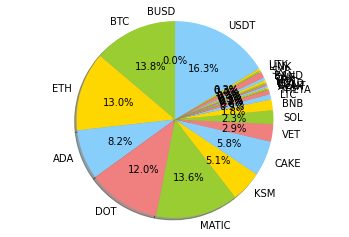

In [14]:
import matplotlib.pyplot as plt

labels = [asset for asset in my_coins]
sizes = [wallet[asset]['Spot_value'] + wallet[asset]['Saving_value'] + wallet[asset]['Stack_value'] for asset in  my_coins]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [15]:
## Bilan

# global balance
balance = 0
total_usdt_invest = 0
total_spot = 0
total_saving = 0
total_stacking = 0
current_value = 0

for asset in wallet:
    if asset != "USDT" and  asset != "BUSD":
        balance += wallet[asset]['Balance']
        total_usdt_invest +=  wallet[asset]['Buy']
        total_usdt_invest -=  wallet[asset]['Sell']
        total_spot += wallet[asset]['Spot_value']
        total_saving += wallet[asset]['Saving_value']
        total_stacking += wallet[asset]['Stack_value']
    else:
        total_usdt_invest +=wallet[asset]['Balance']
        total_spot += wallet[asset]['Spot_value']
        total_saving += wallet[asset]['Saving_value']
        total_stacking += wallet[asset]['Stack_value']

current_value = total_spot + total_saving + total_stacking

print('total_spot',total_spot,'$')
print('total_saving',total_saving,'$')
print('total_stacking',total_stacking,'$')
print('total_usdt_invest',total_usdt_invest,'$')
print('current_value',current_value,'$')
print('balance',balance,'$')
print('plus-value', current_value - (total_usdt_invest*current_value/current_value), '$')
print('plus-value percent', (current_value - (total_usdt_invest*current_value/current_value)) / total_usdt_invest * 100, '%')

total_spot 50.459085557449995 $
total_saving 698.9509415499999 $
total_stacking 1123.7058174000001 $
total_usdt_invest 1879.8972283800003 $
current_value 1873.11584450745 $
balance -6.781383872550023 $
plus-value -6.78138387255035 $
plus-value percent -0.36073162778128043 %


C:\Users\Thibaut - Eva\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  # This is added back by InteractiveShellApp.init_path()


<Figure size 720x720 with 0 Axes>

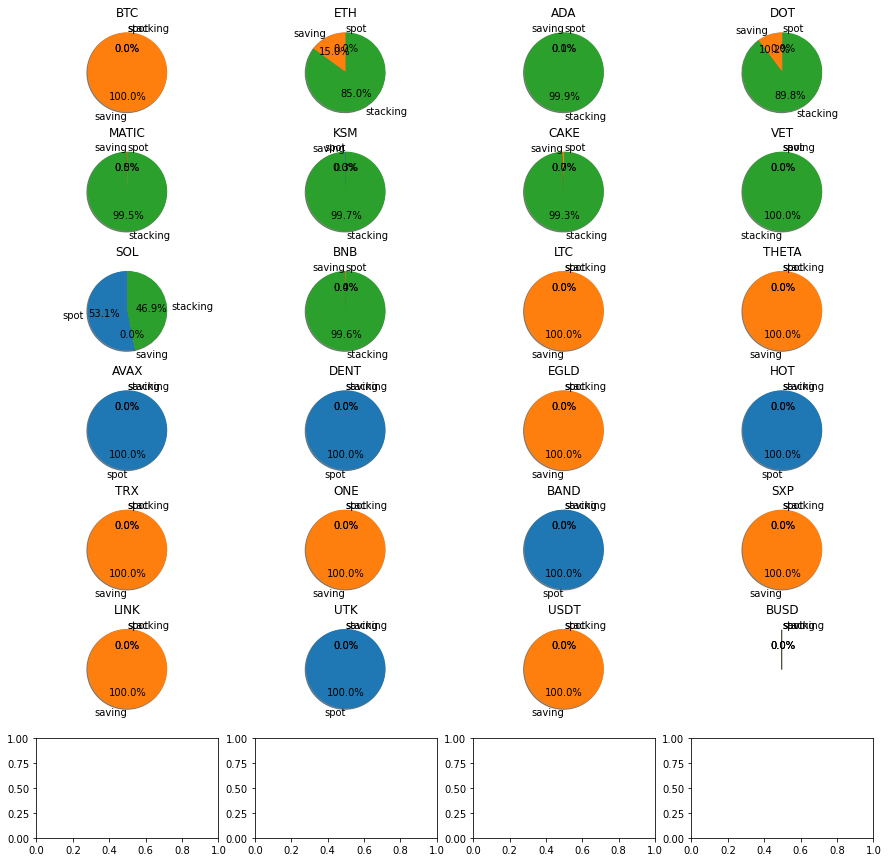

In [16]:
plt.figure(1, figsize=(10, 10))
chats_labels = my_coins
num_columns = 4                                
num_rows  = len(chats_labels) // 4 + 1
fig, ax = plt.subplots(num_rows,num_columns)
label = ['spot', 'saving', "stacking"]
for i, coin in enumerate(chats_labels):
    data = [wallet[coin]['Spot_value'], wallet[coin]['Saving_value'], wallet[coin]['Stack_value']]
    ax[i//4,i%4].set_title(coin)                           # Add 1 to j index
    ax[i//4,i%4].pie(data, labels=label,                 # Add 1 to j index
                autopct='%1.1f%%', shadow=True, startangle=90)
fig.set_size_inches(15,15)
plt.show()

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import IntProgress, widgets

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='#FF4600'
c2='#3DD600' 

color = colorFader(c1,c2,mix=0.5)
for asset in my_coins:
    value=wallet[asset]['Current_market_price']
    maxi=wallet[asset]['ATH']
    color = colorFader(c1,c2,mix=wallet[asset]['ATH_percent'])
    
    display(widgets.FloatProgress(
        value=value,
        min=0,
        max=maxi,
        description=asset,
        bar_style='success',
        style={'bar_color': color},
        orientation='horizontal',
    readout=True,
    readout_format='.1f',
    disabled=False
    ))
    
    display(widgets.HTML(
    value = asset + ": "+str(wallet[asset]['Current_market_price']) + ' / '+ str(wallet[asset]['ATH'])
    ))


FloatProgress(value=43577.36, bar_style='success', description='BTC', max=59500.0, style=ProgressStyle(bar_col…

HTML(value='BTC: 43577.36 / 59500.0')

FloatProgress(value=3001.5, bar_style='success', description='ETH', max=4372.72, style=ProgressStyle(bar_color…

HTML(value='ETH: 3001.5 / 4372.72')

FloatProgress(value=1.4456, bar_style='success', description='ADA', max=2.47, style=ProgressStyle(bar_color='#…

HTML(value='ADA: 1.4456 / 2.47')

FloatProgress(value=21.068, bar_style='success', description='DOT', max=49.78, style=ProgressStyle(bar_color='…

HTML(value='DOT: 21.068 / 49.78')

FloatProgress(value=1.1353, bar_style='success', description='MATIC', max=2.7, style=ProgressStyle(bar_color='…

HTML(value='MATIC: 1.1353 / 2.7')

FloatProgress(value=237.5, bar_style='success', description='KSM', max=625.0, style=ProgressStyle(bar_color='#…

HTML(value='KSM: 237.5 / 625.0')

FloatProgress(value=18.455, bar_style='success', description='CAKE', max=42.98, style=ProgressStyle(bar_color=…

HTML(value='CAKE: 18.455 / 42.98')

FloatProgress(value=0.10808, bar_style='success', description='VET', max=0.25, style=ProgressStyle(bar_color='…

HTML(value='VET: 0.10808 / 0.25')

FloatProgress(value=39.815, bar_style='success', description='SOL', max=58.38, style=ProgressStyle(bar_color='…

HTML(value='SOL: 39.815 / 58.38')

FloatProgress(value=350.95, bar_style='success', description='BNB', max=691.77, style=ProgressStyle(bar_color=…

HTML(value='BNB: 350.95 / 691.77')

FloatProgress(value=153.23, bar_style='success', description='LTC', max=413.49, style=ProgressStyle(bar_color=…

HTML(value='LTC: 153.23 / 413.49')

FloatProgress(value=7.071, bar_style='success', description='THETA', max=13.2, style=ProgressStyle(bar_color='…

HTML(value='THETA: 7.071 / 13.2')

FloatProgress(value=15.564, bar_style='success', description='AVAX', max=43.885, style=ProgressStyle(bar_color…

HTML(value='AVAX: 15.564 / 43.885')

FloatProgress(value=0.0029596, bar_style='success', description='DENT', max=0.011699, style=ProgressStyle(bar_…

HTML(value='DENT: 0.0029596 / 0.011699')

FloatProgress(value=119.91, bar_style='success', description='EGLD', max=205.0, style=ProgressStyle(bar_color=…

HTML(value='EGLD: 119.91 / 205.0')

FloatProgress(value=0.008102, bar_style='success', description='HOT', max=0.01684, style=ProgressStyle(bar_col…

HTML(value='HOT: 0.008102 / 0.01684')

FloatProgress(value=0.07533, bar_style='success', description='TRX', max=0.17, style=ProgressStyle(bar_color='…

HTML(value='TRX: 0.07533 / 0.17')

FloatProgress(value=0.08393, bar_style='success', description='ONE', max=0.18858, style=ProgressStyle(bar_colo…

HTML(value='ONE: 0.08393 / 0.18858')

FloatProgress(value=7.572, bar_style='success', description='BAND', max=20.673, style=ProgressStyle(bar_color=…

HTML(value='BAND: 7.572 / 20.673')

FloatProgress(value=2.648, bar_style='success', description='SXP', max=5.87, style=ProgressStyle(bar_color='#a…

HTML(value='SXP: 2.648 / 5.87')

FloatProgress(value=24.394, bar_style='success', description='LINK', max=53.0, style=ProgressStyle(bar_color='…

HTML(value='LINK: 24.394 / 53.0')

FloatProgress(value=0.3218, bar_style='success', description='UTK', max=1.065, style=ProgressStyle(bar_color='…

HTML(value='UTK: 0.3218 / 1.065')

FloatProgress(value=0.0, bar_style='success', description='USDT', max=0.0, style=ProgressStyle(bar_color='#ff4…

HTML(value='USDT: 0 / 0')

FloatProgress(value=0.9994, bar_style='success', description='BUSD', max=1.0029, style=ProgressStyle(bar_color…

HTML(value='BUSD: 0.9994 / 1.0029')